<a href="https://colab.research.google.com/github/syunar/controlnet_poc/blob/main/demo_lineart_anime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%cd /content
!git clone https://github.com/syunar/controlnet_poc.git
!pip install -q gradio einops transformers open_clip_torch pytorch_lightning==1.7.7 omegaconf xformers==0.0.18 triton==2.0.0 basicsr safetensors fvcore
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Linaqruf/anything-v3.0/resolve/main/anything-v3-full.safetensors -d /content/controlnet_poc/models -o anything-v3-full.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/lllyasviel/ControlNet-v1-1/resolve/main/control_v11p_sd15s2_lineart_anime.pth -d /content/controlnet_poc/models -o control_v11p_sd15s2_lineart_anime.pth



In [ ]:
%cd /content/controlnet_poc

/content/controlnet_poc


In [ ]:
from share import *
import config
from cldm.hack import hack_everything


hack_everything(clip_skip=2)


import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.lineart_anime import LineartAnimeDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

preprocessor = None


model_name = 'control_v11p_sd15s2_lineart_anime'
model = create_model(f'./models/{model_name}.yaml').cpu()
model.load_state_dict(load_state_dict('./models/anything-v3-full.safetensors', location='cuda'), strict=False)
model.load_state_dict(load_state_dict(f'./models/{model_name}.pth', location='cuda'), strict=False)
model = model.cuda()
ddim_sampler = DDIMSampler(model)

logging improved.
logging improved.
Enabled clip hacks.
ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up Me

Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is 768 and using 8 heads.
Setting up Me

In [ ]:
def process(det, image_path, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, strength, scale, seed, eta):
    global preprocessor

    input_image = cv2.imread(image_path)   # reads an image in the BGR format
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)   # BGR -> RGB

    if det == 'Lineart_Anime':
        if not isinstance(preprocessor, LineartAnimeDetector):
            preprocessor = LineartAnimeDetector()

    with torch.no_grad():
        input_image = HWC3(input_image)

        if det == 'None':
            detected_map = input_image.copy()
        else:
            detected_map = preprocessor(resize_image(input_image, detect_resolution))
            detected_map = HWC3(detected_map)

        img = resize_image(input_image, image_resolution)
        H, W, C = img.shape

        detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)

        control = 1.0 - torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [detected_map] + results + [img]

In [ ]:
!mkdir res3_nonepreprocess
!mkdir res3_preprocess

In [ ]:
import glob

imgs = glob.glob(r'/content/controlnet_poc/sample/*')
len(imgs)

12

In [ ]:
import re
from tqdm.notebook import tqdm

for img in tqdm(imgs):
  img_num = re.search("\d+", img).group()

  res = process(det='None',
          image_path=img,
          prompt='japan highschool, love comady',
          a_prompt='masterpiece, best quality, ultra-detailed, illustration, disheveled hair',
          n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, pubic hair,extra digit, fewer digits, cropped, worst quality, low quality',
          num_samples=1,
          image_resolution=728,
          detect_resolution=512,
          ddim_steps=20,
          strength=1.0,
          scale=9.0,
          seed=1234,
          eta=1.0)

  import torch
  import gc
  gc.collect()
  with torch.no_grad():
      torch.cuda.empty_cache()


  from PIL import Image
  im = Image.fromarray(res[1])
  im.save(f"/content/controlnet_poc/res3_nonepreprocess/{img_num}.png")



  0%|          | 0/12 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


In [ ]:
import re
from tqdm.notebook import tqdm

for img in tqdm(imgs):
  img_num = re.search("\d+", img).group()

  res = process(det='Lineart_Anime',
          image_path=img,
          prompt='japan highschool, love comady',
          a_prompt='masterpiece, best quality, ultra-detailed, illustration, disheveled hair',
          n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, pubic hair,extra digit, fewer digits, cropped, worst quality, low quality',
          num_samples=1,
          image_resolution=728,
          detect_resolution=728,
          ddim_steps=20,
          strength=1.0,
          scale=9.0,
          seed=1234,
          eta=1.0)

  import torch
  import gc
  gc.collect()
  with torch.no_grad():
      torch.cuda.empty_cache()


  from PIL import Image
  im = Image.fromarray(res[1])
  im.save(f"/content/controlnet_poc/res3_preprocess/{img_num}.png")


  0%|          | 0/12 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:51<00:00,  2.60s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.60s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]
INFO:pytorch_lightning.utilities.seed:Global seed set to 1234


Data shape for DDIM sampling is (1, 4, 128, 88), eta 1.0
Running DDIM Sampling with 20 timesteps



DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/controlnet_poc/res3_nonepreprocess /content/drive/MyDrive
!cp -r /content/controlnet_poc/res3_preprocess /content/drive/MyDrive

In [ ]:
# import re
# from tqdm.notebook import tqdm

# for img in tqdm(imgs):
#   img_num = re.search("\d+", img).group()

#   res = process(det='None',
#           image_path=img,
#           prompt='',
#           a_prompt='masterpiece, best quality, ultra-detailed, illustration, disheveled hair',
#           n_prompt='longbody, lowres, bad anatomy, bad hands, missing fingers, pubic hair,extra digit, fewer digits, cropped, worst quality, low quality',
#           num_samples=1,
#           image_resolution=728,
#           detect_resolution=512,
#           ddim_steps=20,
#           strength=1.0,
#           scale=9.0,
#           seed=1234,
#           eta=1.0)

#   import torch
#   import gc
#   gc.collect()
#   with torch.no_grad():
#       torch.cuda.empty_cache()


#   from matplotlib import pyplot as plt
#   # Create the figure and subplots
#   fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

#   # Display image 1 on the left subplot
#   ax1.imshow(res[2])
#   ax1.set_title('raw')
#   ax1.axis('off')

#   # Display image 2 on the right subplot
#   ax2.imshow(res[0])
#   ax2.set_title('preprocess')
#   ax2.axis('off')

#   ax3.imshow(res[1])
#   ax3.set_title('results')
#   ax3.axis('off')
#   # Adjust the spacing between subplots
#   # plt.subplots_adjust(wspace=0.3)

#   # Show the figure
#   # plt.show()

#   plt.savefig(f'/content/controlnet_poc/res_nonepreprocess/{img_num}.png', bbox_inches='tight')


In [ ]:
!cp -r /content/controlnet_poc/sample /content/drive/MyDrive

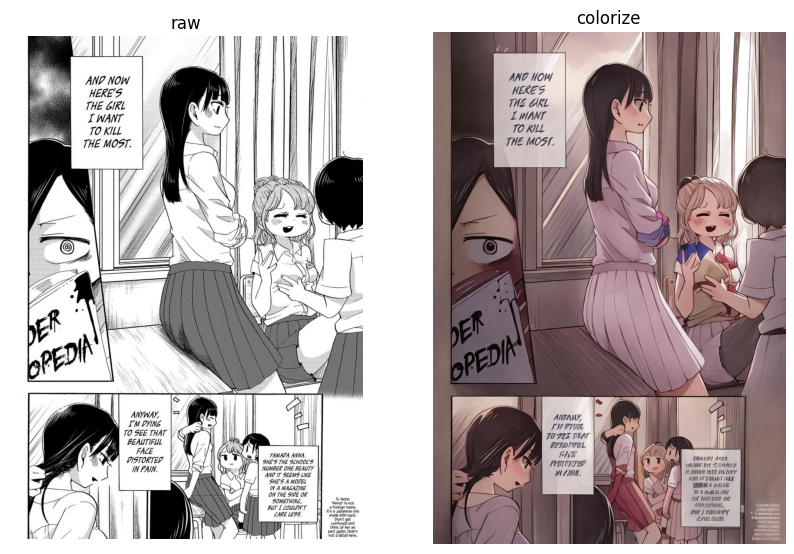

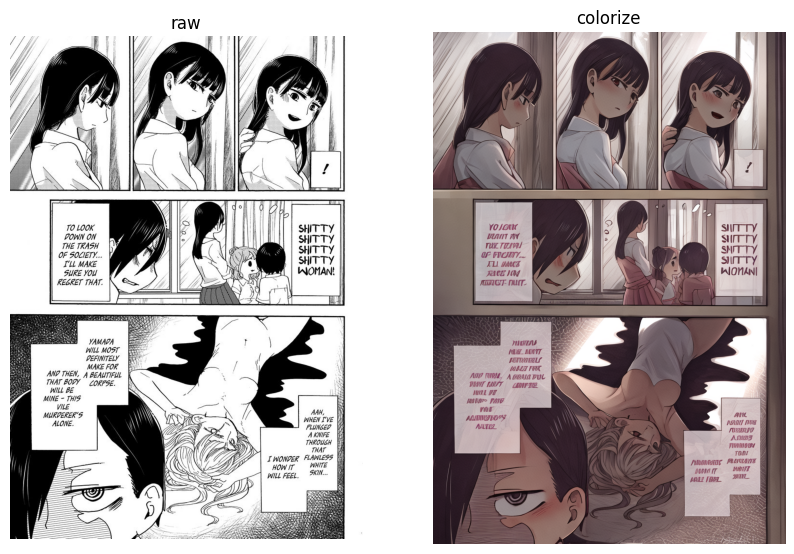

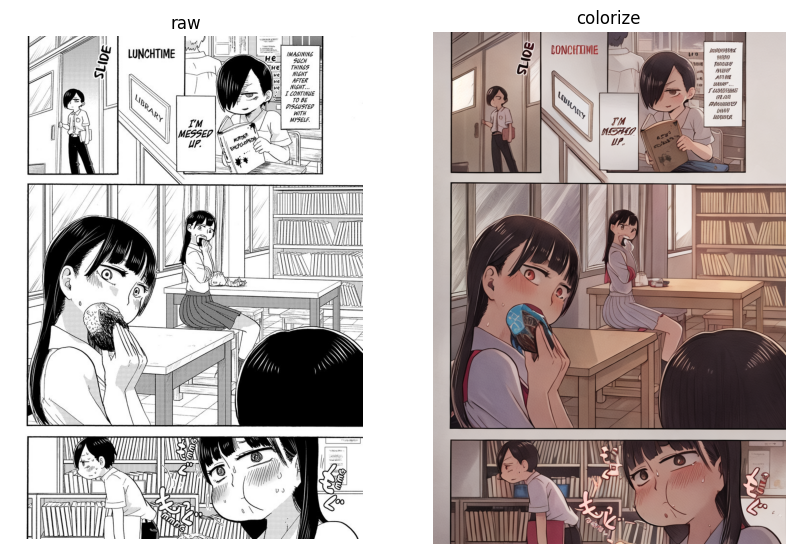

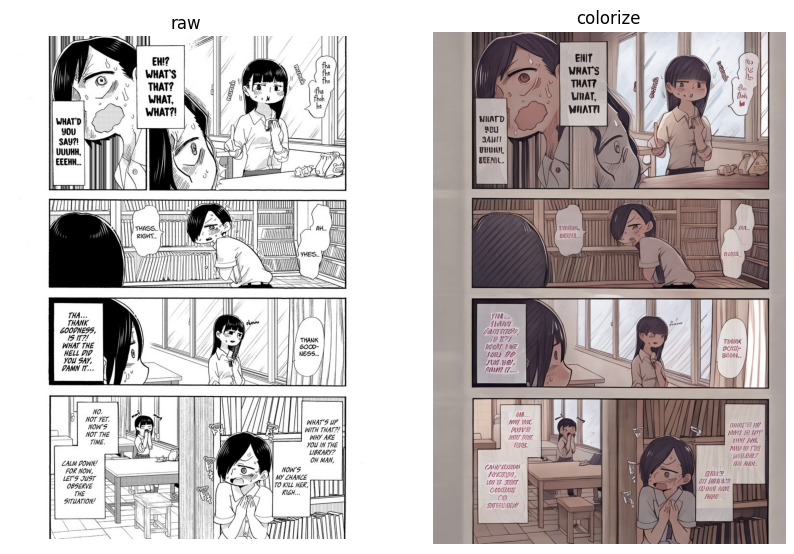

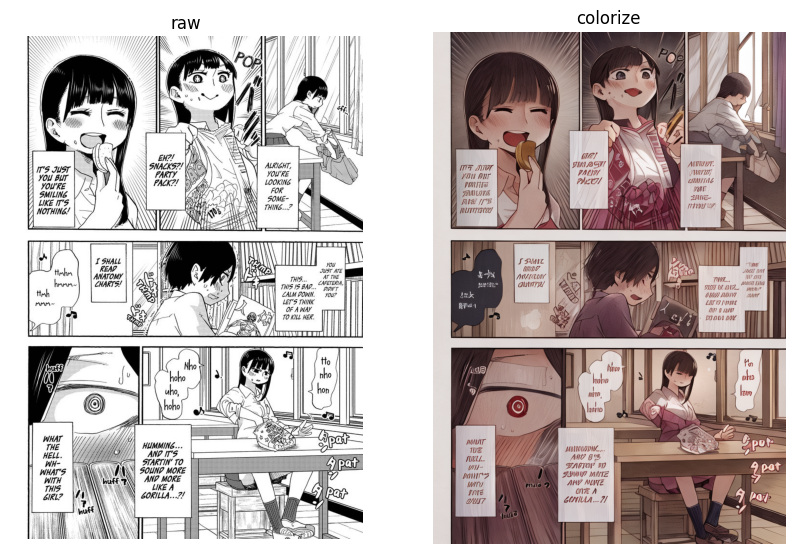

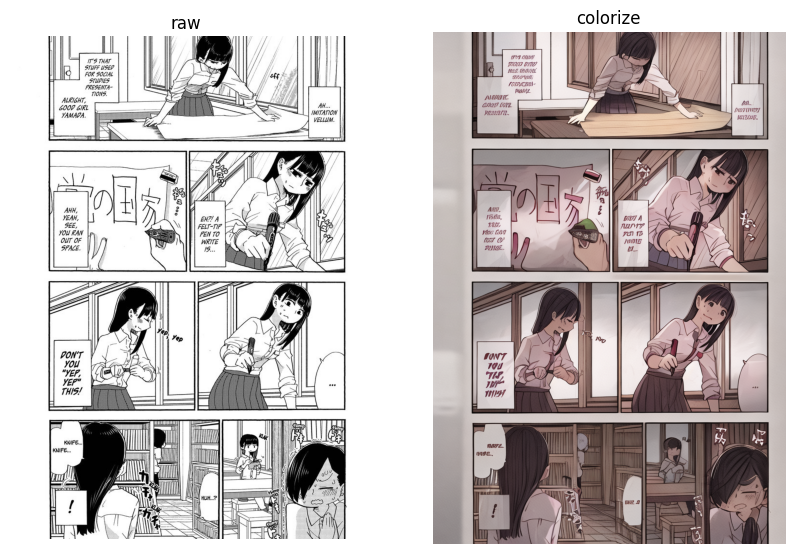

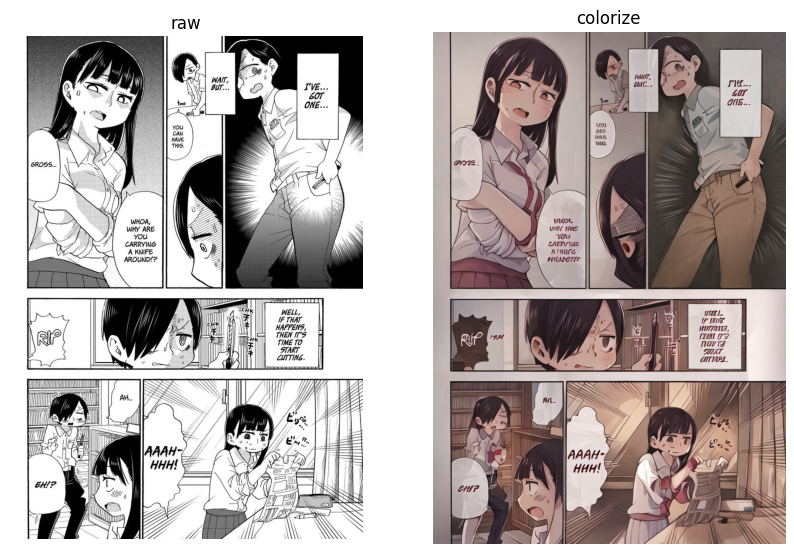

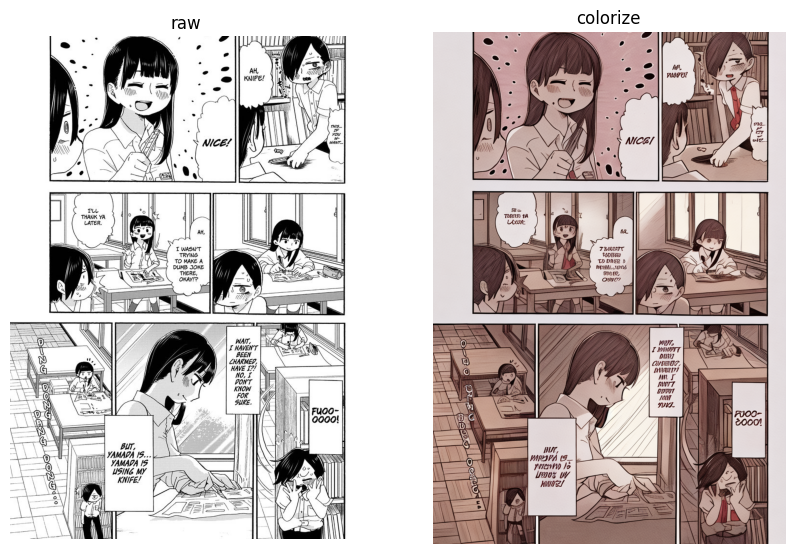

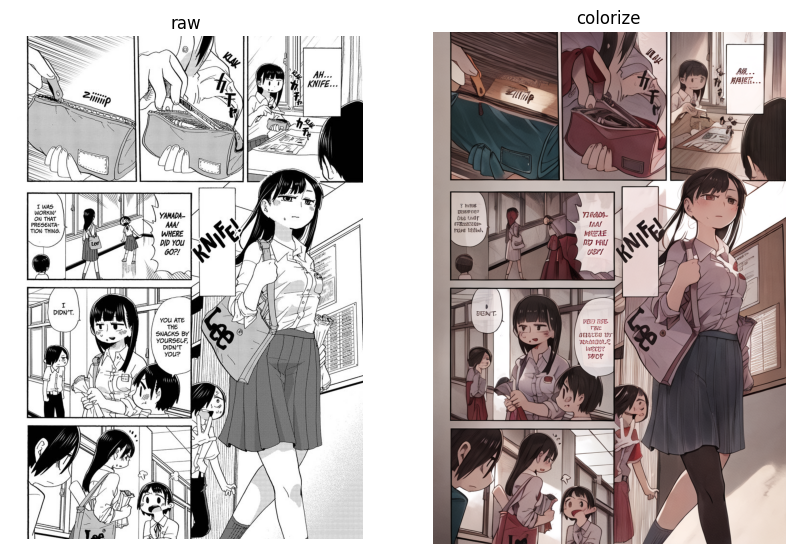

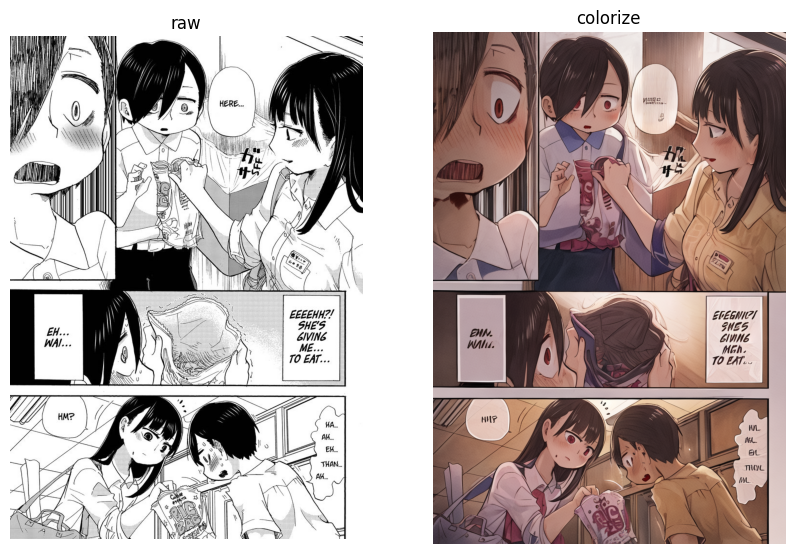

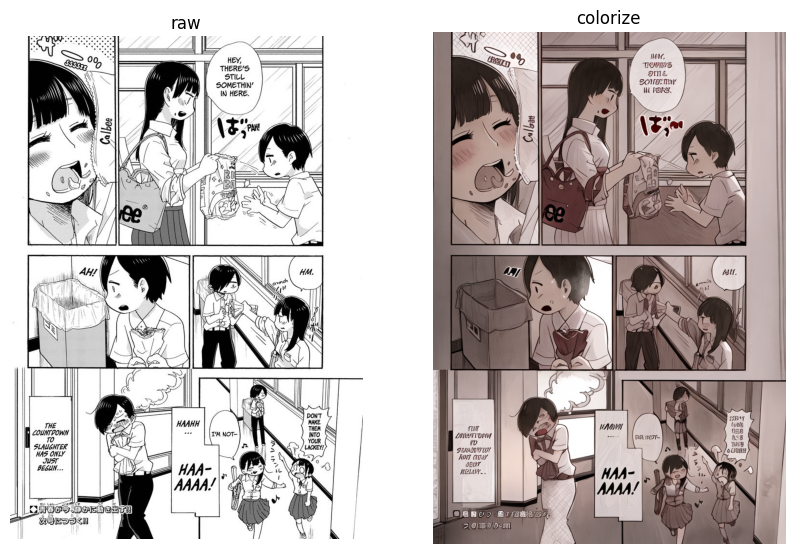

In [ ]:
import matplotlib.pyplot as plt
import cv2

!rm -rf /content/drive/MyDrive/compare_results
!mkdir /content/drive/MyDrive/compare_results
for i in range(4, 16, 1):

    img1 = cv2.imread(f"/content/controlnet_poc/sample/{i}.jpg")
    img2 = cv2.imread(f"/content/controlnet_poc/res3_preprocess/{i}.png")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    # Display image 1 on the left subplot
    ax1.imshow(img1)
    ax1.set_title('raw')
    ax1.axis('off')

    # Display image 2 on the right subplot
    ax2.imshow(img2)
    ax2.set_title('colorize')
    ax2.axis('off')
    plt.savefig(f'/content/drive/MyDrive/compare_results/{i}.png', bbox_inches='tight')

    plt.show()




